In [1]:
import os.path

import tensorflow as tf
import sklearn
import numpy as np

from config import CONFIG
from data_processor import DataProcessor
from evaluation_utils import get_test_data_and_labels
from data_loader_class import DataLoader
from gradcam import GradCAM

2025-01-31 14:27:32 - app_logger - INFO - Logger initialized correctly



In [2]:
path = r'C:\Users\dicia\PycharmProjects\PythonProject\Experiments\300125\03\models\final_model.keras'
model = tf.keras.models.load_model(path)

In [3]:
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ overall_input_layer             │ (None, 224, 224, 3)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_small (Functional)     │ (None, 768)            │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 768)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,963,621 (568.25 MB)

 Trainable params: 49,653,857 (189.41 MB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 99,307,716 (378.83 MB)

In [4]:
test_loader = DataLoader(split='test')

images, labels = get_test_data_and_labels(test_loader)

In [27]:
features_extractor =  tf.keras.models.Model(
        inputs=model.input,
        outputs=model.get_layer('batch_norm').output
    )

# features_extractor.summary()

In [30]:
input_data = images
print(input_data.shape)
preds = features_extractor.predict(input_data)


(473, 224, 224, 3)
15/15 ━━━━━━━━━━━━━━━━━━━━ 121s 8s/step


In [31]:
preds.shape

(473, 768)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate

In [39]:
X_train, X_test, y_train, y_test = train_test_split(preds, labels, test_size=0.3, random_state=42)

# 2. Normalizza le caratteristiche con StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Creazione e addestramento del modello SVM
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# 4. Predizione sui dati di test
y_pred = svm_classifier.predict(X_test)

# 5. Valutazione del modello
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7605633802816901

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.86      0.83       100
         1.0       0.61      0.52      0.56        42

    accuracy                           0.76       142
   macro avg       0.71      0.69      0.70       142
weighted avg       0.75      0.76      0.75       142



In [37]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 alberi
rf_classifier.fit(X_train, y_train)

# 3. Predizione sui dati di test
y_pred = rf_classifier.predict(X_test)

# 4. Valutazione del modello
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8380281690140845

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.98      0.89       100
         1.0       0.91      0.50      0.65        42

    accuracy                           0.84       142
   macro avg       0.87      0.74      0.77       142
weighted avg       0.85      0.84      0.82       142



In [45]:
scaler = StandardScaler()
preds_scaled = scaler.fit_transform(preds)
svm_classifier = SVC(kernel='linear', random_state=42)

# Calcolo delle prestazioni usando Cross-Validation (ad esempio k=5 folds)
svm_scores = cross_val_score(svm_classifier, preds_scaled, labels, cv=5, scoring='accuracy')

# Media e deviazione standard delle prestazioni
print("SVM - Media accuracy:", np.mean(svm_scores))
print("SVM - Deviazione standard accuracy:", np.std(svm_scores))

# 2. CROSS-VALIDATION PER RANDOM FOREST
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Calcolo delle prestazioni usando Cross-Validation (k=5 folds)
rf_scores = cross_val_score(rf_classifier, preds, labels, cv=5, scoring='accuracy')

# Media e deviazione standard delle prestazioni
print("Random Forest - Media accuracy:", np.mean(rf_scores))
print("Random Forest - Deviazione standard accuracy:", np.std(rf_scores))

SVM - Media accuracy: 0.7611646136618141
SVM - Deviazione standard accuracy: 0.016191447500996655
Random Forest - Media accuracy: 0.8223516237402017
Random Forest - Deviazione standard accuracy: 0.02907556935510266


In [47]:
# Calcolo delle metriche con cross_validate
metrics = ['accuracy', 'precision', 'recall']
scorings = {metric: metric for metric in metrics}

rf_results = cross_validate(rf_classifier, preds, labels, cv=5, scoring=scorings)

# Stampare le metriche calcolate
for metric in metrics:
    print(f"Random Forest - {metric.capitalize()}: Media {np.mean(rf_results[f'test_{metric}']):.2f}, "
          f"Deviazione {np.std(rf_results[f'test_{metric}']):.2f}")

Random Forest - Accuracy: Media 0.82, Deviazione 0.03
Random Forest - Precision: Media 0.71, Deviazione 0.09
Random Forest - Recall: Media 0.44, Deviazione 0.10


In [7]:
import pandas as pd
import nrrd
train_split = r'C:\Users\dicia\PycharmProjects\PythonProject\split\test_split.csv'
dataset = pd.read_csv(train_split)



In [8]:
img = dataset['Full_slice'].iloc[5]
img_arr = nrrd.read(os.path.join(CONFIG['data']['train_path'], img))[0]

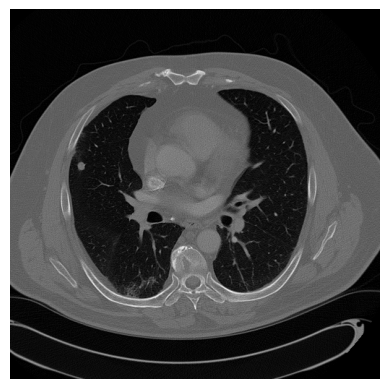

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(img_arr, cmap='gray')
plt.axis('off')
plt.savefig('test.png')

In [10]:
proc = DataProcessor(img_arr[np.newaxis,...,np.newaxis])

In [11]:
proc.apply_pipeline()
img_prep = proc.data

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

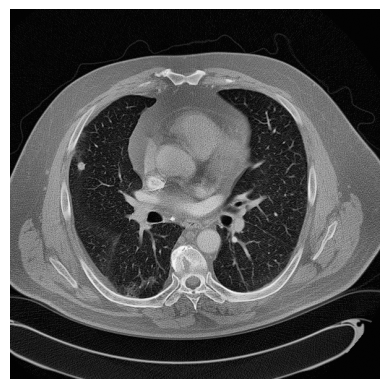

In [12]:
plt.imshow(img_prep[0,...,0], cmap='gray')
plt.axis('off')